In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Quantum measurements: 
# Multi-qubit operators and Qiskit demo

## Introduction

In this notebook, we will learn the theory behind the computation of expectation values of multi-qubit operators, and how to calculate them in Qiskit. We will then apply those functionalities to calculate the ground state of the hydrogen molecule. 

In [2]:
import numpy as np

from qiskit import QuantumCircuit

from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_aer.primitives import Estimator, Sampler
from qiskit.quantum_info.operators import Operator, Pauli


from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.mappers               import JordanWignerMapper, ParityMapper
import qiskit_nature 
qiskit_nature.settings.use_pauli_sum_op = False 

## A. A two-qubit operator

We define a two-qubit operator: $O = Z \otimes X $, 

In [3]:
op = Pauli("ZX")
print(op.to_matrix())

[[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]]


and a test two-qubit quantum state:

[0.90612745+0.j 0.37533028+0.j 0.18023996+0.j 0.07465783+0.j]


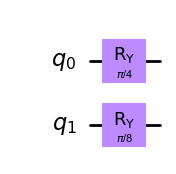

In [4]:
circuit = QuantumCircuit(2)
theta = np.pi/4 #just a arbitrary value
circuit.ry(theta,0)
circuit.ry(theta/2,1)

psi = Statevector(circuit)
print(psi.data)

circuit.draw(output = 'mpl')

### Evaluate the expectation value the exact way

In [5]:
exact_expectation = psi.expectation_value(op).real
print('Exact expectation value:', exact_expectation)

Exact expectation value: 0.6532814824381883


### Compute with post-rotations and measurements
As in the single-qubit case, we insert the needed rotation, called post-rotation, before measurements.
Again, the qubit 0 needs to be rotated using the Hadamard gate.

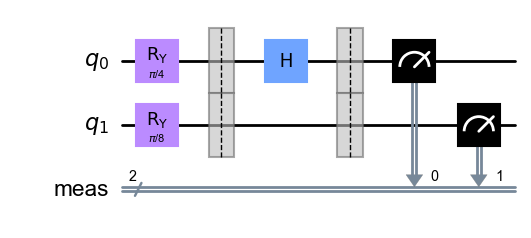

In [6]:
circuit = QuantumCircuit(2)
circuit.ry(theta,0)
circuit.ry(theta/2,1)

circuit.barrier()
circuit.h(0)  # <- post-rotation on qubit on which operator X is defined

circuit.measure_all()
circuit.draw(output='mpl')

In [7]:
nshots = 8192
sampler = Sampler()
result = sampler.run(circuit, shots=nshots).result()
quasi_dist = result.quasi_dists[0]

Find the diagonalized operator $R^{-1} O R$ that is measured in the rotated basis. By contruction, we know it is diagonal. We need to check the sign of the eigenvalues.

In [8]:
op_circuit = QuantumCircuit(2)
op_circuit.h(0)

op_diagonalized = Operator(op_circuit).compose(op).compose(Operator(op_circuit))
print(op_diagonalized)
print(op_diagonalized.to_matrix())

Operator([[ 1.00000000e+00+0.j,  2.23711432e-17+0.j,  0.00000000e+00+0.j,
            0.00000000e+00+0.j],
          [-2.23711432e-17+0.j, -1.00000000e+00+0.j,  0.00000000e+00+0.j,
            0.00000000e+00+0.j],
          [ 0.00000000e+00+0.j,  0.00000000e+00+0.j, -1.00000000e+00+0.j,
           -2.23711432e-17+0.j],
          [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  2.23711432e-17+0.j,
            1.00000000e+00+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
[[ 1.00000000e+00+0.j  2.23711432e-17+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [-2.23711432e-17+0.j -1.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j -1.00000000e+00+0.j
  -2.23711432e-17+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  2.23711432e-17+0.j
   1.00000000e+00+0.j]]


In [9]:
cnt00 = quasi_dist[0]
cnt01 = quasi_dist[1]
cnt10 = quasi_dist[2]
cnt11 = quasi_dist[3]

expectation_from_counts = cnt00 - cnt01 - cnt10 + cnt11  
#the +1 / -1 sign pattern is from the R^-1 O R diagonalized op.

print('Expectation from counts (manual way):', expectation_from_counts)
print('Exact expectation (scalar product):', exact_expectation)

Expectation from counts (manual way): 0.660400390625
Exact expectation (scalar product): 0.6532814824381883


## B. A sum of two operators

In [10]:
op1 = SparsePauliOp.from_list([("IZ", 0.6)])
op_sum = op + op1
print ("ZX\n",op.to_matrix())
print ("IZ\n",op1.to_matrix())
print ("ZX+0.6*IZ\n",op_sum.to_matrix())

ZX
 [[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]]
IZ
 [[ 0.6+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.6+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0.6+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -0.6+0.j]]
ZX+0.6*IZ
 [[ 0.6+0.j  1. +0.j  0. +0.j  0. +0.j]
 [ 1. +0.j -0.6+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0.6+0.j -1. +0.j]
 [ 0. +0.j  0. +0.j -1. +0.j -0.6+0.j]]


### Evaluate the expectation value the exact way

In [11]:
exact_expectation = psi.expectation_value(op1).real
print('Exact expectation value op1:', exact_expectation)
exact_expectation = psi.expectation_value(op_sum).real
print('Exact expectation value op_sum:', exact_expectation)

Exact expectation value op1: 0.4242640687119285
Exact expectation value op_sum: 1.0775455511501169


### Compute with post-rotations and measurements
We have to re-run the circuit with no post-rotations, as there is no way to recycle the counts obtained before.

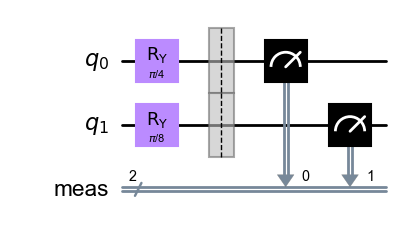

In [12]:
circuit = QuantumCircuit(2)
circuit.ry(theta,0)
circuit.ry(theta/2,1)

circuit.measure_all()
circuit.draw(output='mpl')

In [13]:
nshots = 8192
estimator = Estimator(run_options={"shots": nshots, "seed": 12 }, approximation=True)
expectation_value_op1 = estimator.run(circuit, op1).result().values
expectation_value_op_sum = estimator.run(circuit, op_sum).result().values

print('Expectation for op1 (with estimator):', expectation_value_op1.real)
print('Expectation for op_sum (with estimator):',expectation_value_op_sum.real)
print('Exact expectation op_sum (scalar product):', exact_expectation)

Expectation for op1 (with estimator): [0.42423207]
Expectation for op_sum (with estimator): [1.07748009]
Exact expectation op_sum (scalar product): 1.0775455511501169


## Grouped Paulis

We can measure operators of the kind $\{ Z \otimes Z, Z \otimes I, I \otimes Z \}$ using the same count dataset, but with different $\pm 1$ sign patterns. The same is true for  $\{ Z \otimes X, I \otimes X\}$, etc.

This technique is called Grouped Paulis, and can be unlocked in practical VQE runs. It usually saves some circuit repetitions, but the expectation values $\langle ZZ \rangle, \langle ZI\rangle, \cdots$ become correlated, so this needs to be taken into account when computing the standard error of the sum (including the covariance in the formula, which otherwise is trivial).

# The fast Qiskit way

You can generate the sequence of circuits with correct post-rotations using `PauliExpectation`. This is an expectation converter for Pauli-basis observables that changes Pauli measurements to a diagonal $({Z, I}^n)$ basis and appends circuit post-rotations to the measured state function. It optionally groups the Paulis with the same post-rotations (those that commute with one another, or form Abelian groups) into single measurements to reduce circuit execution overhead.

In [14]:
circuit = QuantumCircuit(2)
circuit.ry(theta,0)
circuit.ry(theta/2,1)

circuit.draw()

┌─────────┐
q_0: ┤ Ry(π/4) ├
     ├─────────┤
q_1: ┤ Ry(π/8) ├
     └─────────┘

In [15]:
estimator = Estimator(run_options={"shots": 8192, "seed": 570}, approximation=True)
expectation_value = estimator.run(circuit, op_sum).result().values

print(expectation_value.real)

[1.06778738]


## The hydrogen molecule
<a id="h2"></a>

Now we will apply the functionalities we have learnt to calculate the ground state of a hydrogen molecule. In the STO-3G minimal basis set, four qubits are required - one for each spin orbital.

We first need to set up a PySCF driver and the Electronic Structure Problem to generate the second-quantized operator and a qubit converter that will map it to a qubit operator. Here we use parity mapping, which allows us to remove two qubits by exploiting known symmetries arising from the mapping.

In [16]:
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()

mapper = ParityMapper(num_particles=problem.num_particles)
hamiltonian = problem.hamiltonian

second_q_op = hamiltonian.second_q_op()

qubit_p_op = mapper.map(second_q_op)


print('H_2 Hamiltonian in qubit form:')
for pauli, coeff in sorted(qubit_p_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

H_2 Hamiltonian in qubit form:
-1.05237325 * II
+0.39793742 * IZ
+0.18093120 * XX
-0.39793742 * ZI
-0.01128010 * ZZ


/Users/iuliazidaru/opt/anaconda3/envs/chem/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Let's diagonalize the operator to compute the exact ground state energy. 
Exact diagonalization is possible only for small systems, so we do it to benchmark the subsequent VQE algorithm.

In [17]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
np_solver = NumPyMinimumEigensolver()

exact_run = np_solver.compute_minimum_eigenvalue(operator=qubit_p_op)
ground_state_energy = exact_run.eigenvalue.real

print('\nExact eigensolver\n',exact_run, "\n \n Ground state energy:", ground_state_energy)


Exact eigensolver
 {   'aux_operators_evaluated': None,
    'eigenstate': Statevector([-8.32667268e-17-3.64291930e-17j,
              7.22856695e-01+6.81936898e-01j,
             -8.11307233e-02-7.65380388e-02j,
             -4.44089210e-16+1.38777878e-16j],
            dims=(2, 2)),
    'eigenvalue': -1.8572750302023784} 
 
 Ground state energy: -1.8572750302023784


We will work with a heuristic circuit.

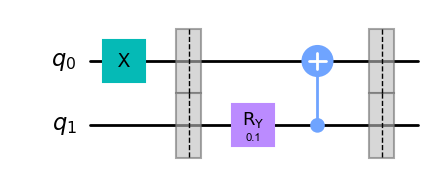

In [18]:
qc = QuantumCircuit(2)
theta =0.1

qc.x(0)

qc.barrier()
qc.ry(theta, 1)

qc.cx(1,0)

qc.barrier()

qc.draw(output='mpl')

### Compute the expectation
Since there is only one parameter $\theta$, we can brute-force scan the whole domain:

In [19]:
theta = 0.0
Nmesh = 100

list_theta_ry = []
list_en_ry = []

for i in range(Nmesh):
    qc = QuantumCircuit(2)
    theta += (2*np.pi/Nmesh)

    qc.x(0)

    qc.barrier()
    qc.ry(theta, 1)

    qc.cx(1,0)

    qc.barrier()
    
    estimator = Estimator(run_options={"shots": nshots, "seed": 12 }, approximation=True)
    expectation_value = estimator.run(qc, qubit_p_op).result().values
    en = expectation_value.real

    list_theta_ry.append(theta)
    list_en_ry.append(en)

### Plot to compare the energies 

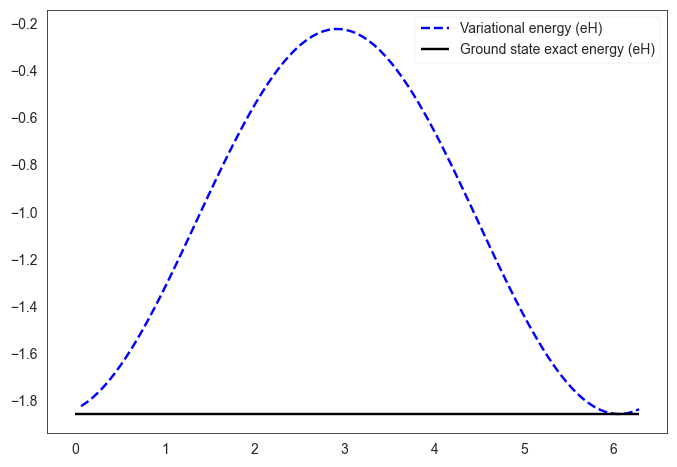

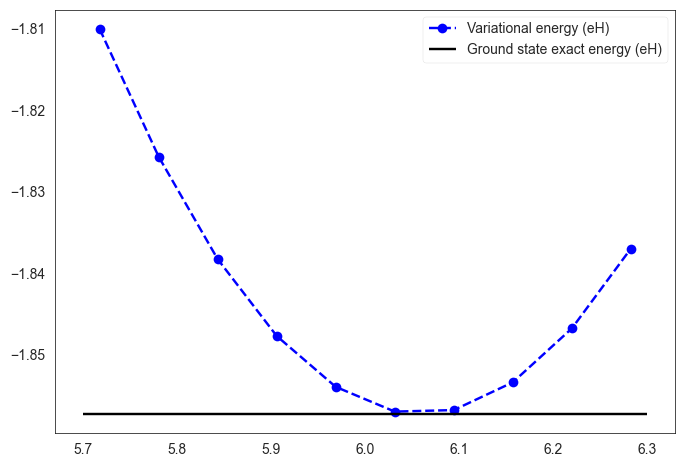

In [20]:
import matplotlib.pyplot as plt
plt.plot(list_theta_ry,list_en_ry, label='Variational energy (eH)', linestyle='--', color='blue')
plt.hlines(ground_state_energy, 0, 2*np.pi, colors='k', linestyles='solid', label='Ground state exact energy (eH)')
plt.legend(framealpha=1, frameon=True);
plt.show()

#Zoom in
plt.plot(list_theta_ry[90:100],list_en_ry[90:100], label='Variational energy (eH)', linestyle='--', marker='o', color='blue')
plt.hlines(ground_state_energy, 5.7, 6.3, colors='k', linestyles='solid', label='Ground state exact energy (eH)')
plt.legend(framealpha=1, frameon=True);

plt.show()

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>
